# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

In [ ]:
%%shell
jupyter nbconvert --to html "/Lab2_Cats_vs_Dogs.ipynb"

[NbConvertApp] Converting notebook /Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 17 image(s).
[NbConvertApp] Writing 1339026 bytes to /Lab2_Cats_vs_Dogs.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1Gs9F_nBo8WGZvNI0wHXrAQuwVzWT4vv8/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:05<00:00, 29.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

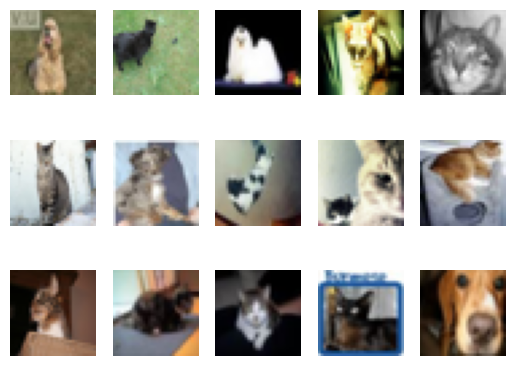

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
print(f"There are: {len(train_loader)+len(test_loader)+len(val_loader)} combined examples for the cat and dog classes, {len(val_loader)} validation examples, and {len(test_loader)} test examples.")

There are: 12000 combined examples for the cat and dog classes, 2000 validation examples, and 2000 test examples.


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

The validation set is used to tune hyperparameters by testing our model on data it has not seen before. If the performance of the models is judged using the training set loss/error the model is likely to be overfit to training data and perform poorly on new samples.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)


torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [ ]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In the small_net there are 5x3x3x3+5+245+1 = 386 parameters. In the large_net there are 5x3x5x5+5+10x5x5x5+10+32x250+32+32+1 = 9705 parameters.

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

The default batch_size is 64, the learning_rate is 0.01 and the num_epochs is 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

The first 5 files are saved after each epoch (for a total of 5 epochs), and they contain the model parameters for the neural network after each epoch. The next 4 files are csv files that respectively contain the training error, training loss, validation error, and validation loss for each epoch. Here is a complete list of the files:

model_small_bs64_lr0.01_epoch0.pth,

model_small_bs64_lr0.01_epoch1.pth,

model_small_bs64_lr0.01_epoch2.pth,

model_small_bs64_lr0.01_epoch3.pth,

model_small_bs64_lr0.01_epoch4.pth,

model_small_bs64_lr0.01_epoch4_train_err.csv,

model_small_bs64_lr0.01_epoch4_train_loss.csv,

model_small_bs64_lr0.01_epoch4_val_err.csv,

model_small_bs64_lr0.01_epoch4_val_loss.csv.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
small_net=SmallNet()
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43375, Train loss: 0.6805108742713928 |Validation err: 0.381, Validation loss: 0.6601939871907234
Epoch 2: Train err: 0.382625, Train loss: 0.6531455497741699 |Validation err: 0.399, Validation loss: 0.6717473324388266
Epoch 3: Train err: 0.354375, Train loss: 0.632803337097168 |Validation err: 0.347, Validation loss: 0.627197615802288
Epoch 4: Train err: 0.33525, Train loss: 0.6184419069290161 |Validation err: 0.3835, Validation loss: 0.6464294362813234
Epoch 5: Train err: 0.326, Train loss: 0.6069381921291351 |Validation err: 0.327, Validation loss: 0.6270715426653624
Epoch 6: Train err: 0.317125, Train loss: 0.5948983132839203 |Validation err: 0.3425, Validation loss: 0.6228860728442669
Epoch 7: Train err: 0.312375, Train loss: 0.5906917459964752 |Validation err: 0.3325, Validation loss: 0.6045422926545143
Epoch 8: Train err: 0.299125, Train loss: 0.5820075099468232 |Validation err: 0.3

In [ ]:
large_net = LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.444625, Train loss: 0.6900211324691773 |Validation err: 0.4305, Validation loss: 0.6807530857622623
Epoch 2: Train err: 0.418875, Train loss: 0.6781997265815735 |Validation err: 0.4125, Validation loss: 0.6741086076945066
Epoch 3: Train err: 0.39825, Train loss: 0.6658710074424744 |Validation err: 0.394, Validation loss: 0.6518888883292675
Epoch 4: Train err: 0.3745, Train loss: 0.6488627505302429 |Validation err: 0.408, Validation loss: 0.6639942992478609
Epoch 5: Train err: 0.35475, Train loss: 0.633074896812439 |Validation err: 0.352, Validation loss: 0.6291442140936852
Epoch 6: Train err: 0.340625, Train loss: 0.6164079172611237 |Validation err: 0.3425, Validation loss: 0.6155355125665665
Epoch 7: Train err: 0.3265, Train loss: 0.6007295575141907 |Validation err: 0.3395, Validation loss: 0.6099893599748611
Epoch 8: Train err: 0.313375, Train loss: 0.5828288238048553 |Validation err: 0.

The large network took longer, this is because it has significantly more parameters to go through each pass which requires more time.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

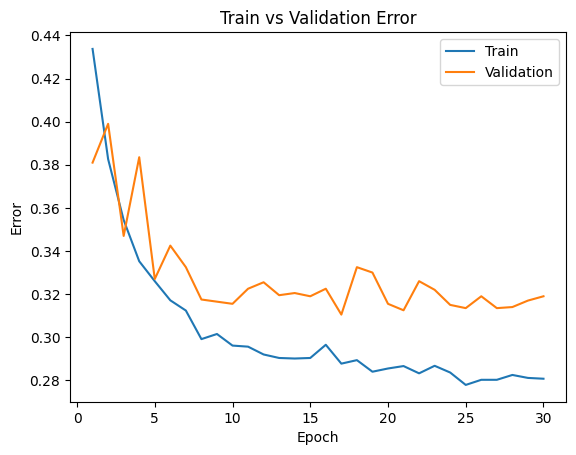

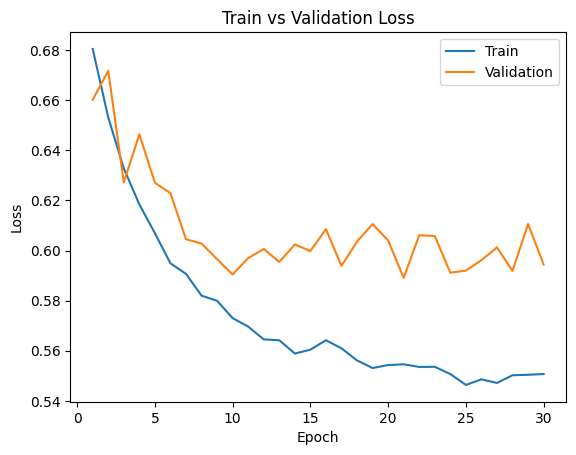

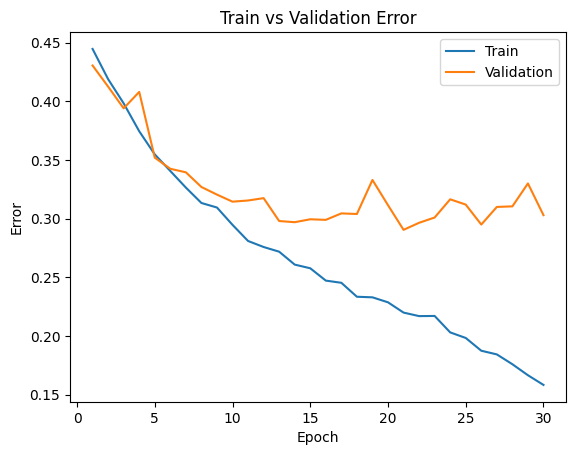

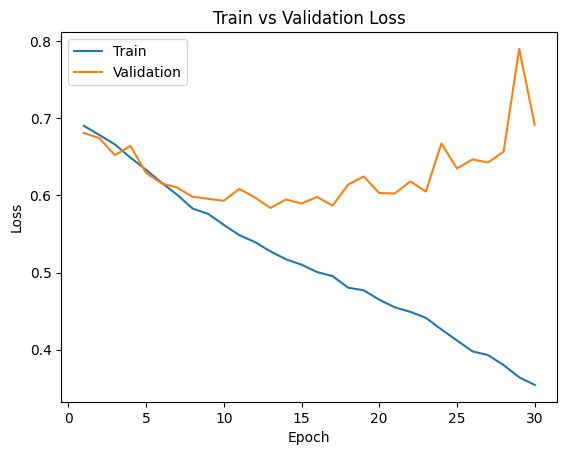

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

For the small net the training error and loss resembles a curve with a more significant drop off initially which tapers off. This resembles a fairly good fit as it also matches with the decreasing validation curve. The large net however, does have occurances of overfitting. In the train and validation error plot the validation curve does not decrease with the training curve, it remains relatively high at around 0.30. Further, in the train vs validation loss plot, the validation curve increases which indicates overfitting.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589716911316 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.68965969607234
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419748306275 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267811775207 |Validation err: 

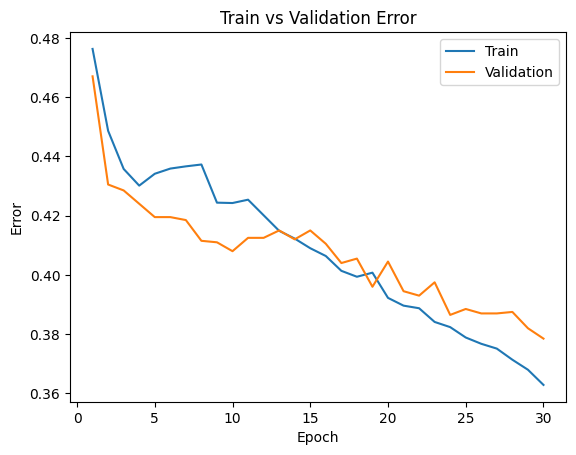

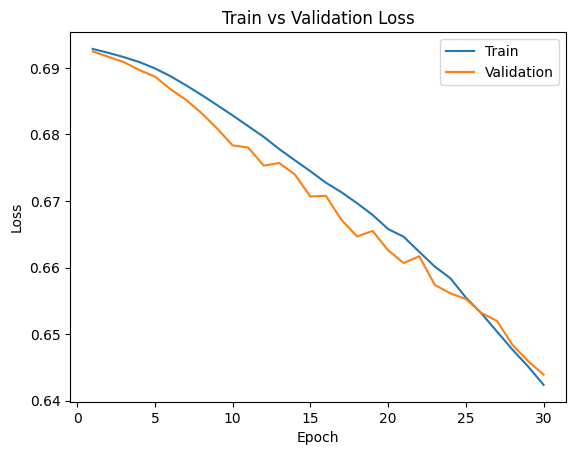

In [ ]:
model_path_large_lr_0001 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large_lr_0001)

The model took nearly the same amount of time to train (only 1 second shorter). By decreasing the learning rate there is significantly less overfitting and the model seems to achieve a good fit.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743808445930481 |Validation err: 0.3565, Validation loss: 0.6350402887910604
Epoch 2: Train err: 0.36925, Train loss: 0.6415545463562011 |Validation err: 0.3515, Validation loss: 0.6243696268647909
Epoch 3: Train err: 0.366, Train loss: 0.6304733338356018 |Validation err: 0.3475, Validation loss: 0.6173483617603779
Epoch 4: Train err: 0.35775, Train loss: 0.6251179370880127 |Validation err: 0.3345, Validation loss: 0.620793430134654
Epoch 5: Train err: 0.33675, Train loss: 0.6045795600414277 |Validation err: 0.329, Validation loss: 0.5937281344085932
Epoch 6: Train err: 0.31775, Train loss: 0.5828781847953797 |Validation err: 0.3275, Validation loss: 0.6041664052754641
Epoch 7: Train err: 0.3195, Train loss: 0.5794640259742737 |Validation err: 0.334, Validation loss: 0.6052154619246721
Epoch 8: Train err: 0.311875, Train loss: 0.5757701637744903 |Validation err: 0.318,

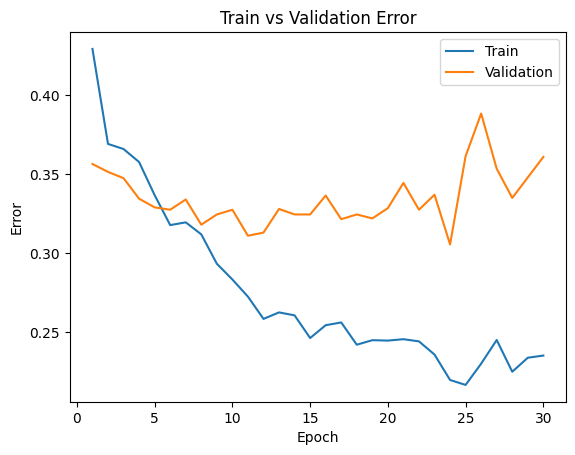

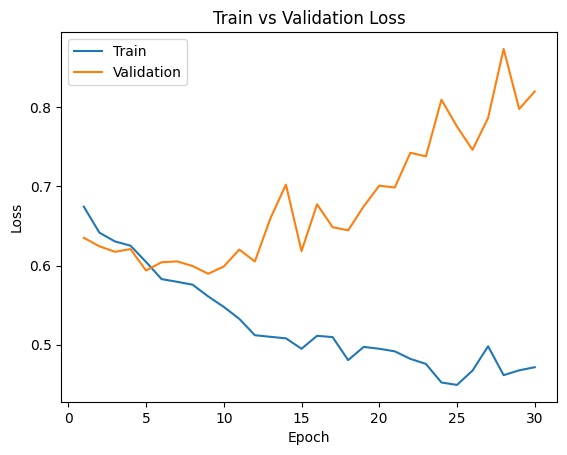

In [ ]:
model_path_large_lr_0001 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large_lr_0001)

The model took slightly less time to train. By increasing the learning rate, the problem with overfitting worsens. This is due to the larger weight updates which creates worse generalizations with the model which can be seen in the validation loss and error.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.692410409450531 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770620465279 |Validation err: 0.411, Val

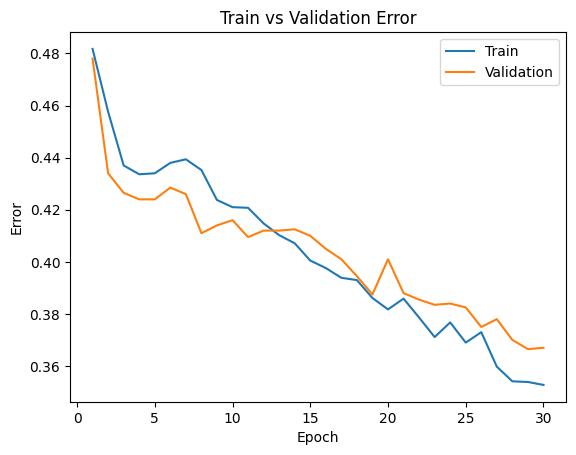

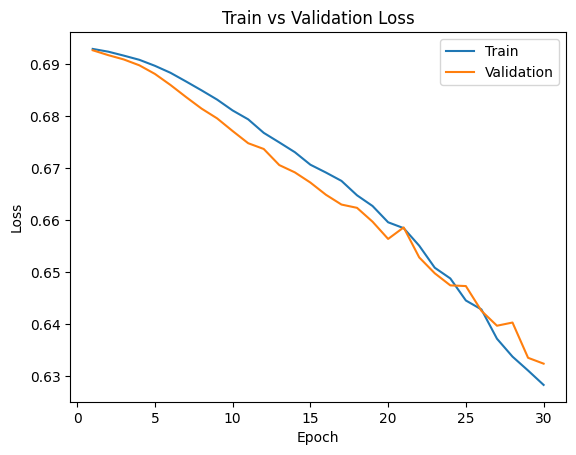

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
model_path_large_bs512 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_bs512)

Increasing the batch size makes training the model a little faster as there are fewer sets of batches and updates per epoch. The training curves are smoother and there is less overfitting.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44075, Train loss: 0.6802962548732757 |Validation err: 0.3815, Validation loss: 0.6523765053749084
Epoch 2: Train err: 0.363875, Train loss: 0.6397789194583893 |Validation err: 0.354, Validation loss: 0.6248284170627594
Epoch 3: Train err: 0.333, Train loss: 0.6125355584621429 |Validation err: 0.3265, Validation loss: 0.6000362031459808
Epoch 4: Train err: 0.31675, Train loss: 0.591859345972538 |Validation err: 0.302, Validation loss: 0.5967739686965943
Epoch 5: Train err: 0.297, Train loss: 0.5722447559833527 |Validation err: 0.3045, Validation loss: 0.5740247373580932
Epoch 6: Train err: 0.280125, Train loss: 0.5503485835790635 |Validation err: 0.3, Validation loss: 0.5898042197227478
Epoch 7: Train err: 0.270625, Train loss: 0.5350774740576744 |Validation err: 0.304, Validation loss: 0.5966335062980652
Epoch 8: Train err: 0.258875, Train loss: 0.5158957667946815 |Validation err: 0.32, V

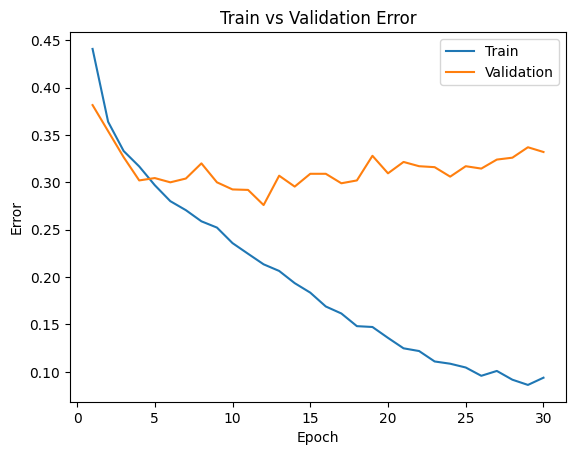

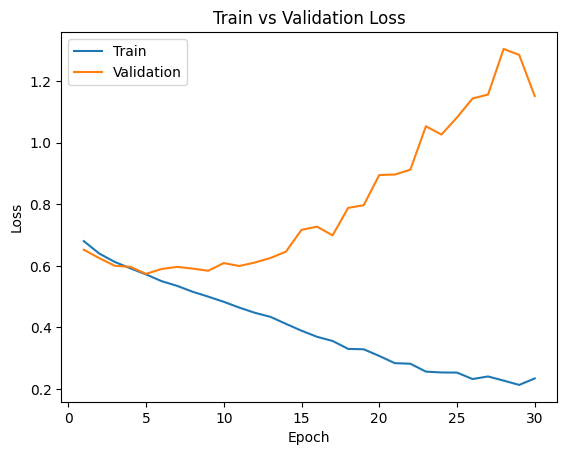

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16)
model_path_large_bs16 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_bs16)

Decreasing the batch size makes training the model much longer. It also leads to overfitting seen clearly in the loss plot due to the batch sizes causing the model to learn details unique to the training data that don't help generalize new examples.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

The new set of hyperparameters will be small net, batch size=256 and learning rate=0.05. This is because earlier in the lab it was discovered that the small net had less overfitting and a smaller training weight(<0.01) reduced overfitting as well. Compared to a batch size of 16 or 64, a larger batch size of 512 also decreased the model overfitting.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.463875, Train loss: 0.6895074136555195 |Validation err: 0.459, Validation loss: 0.6862325072288513
Epoch 2: Train err: 0.4405, Train loss: 0.6808657180517912 |Validation err: 0.433, Validation loss: 0.6787364333868027
Epoch 3: Train err: 0.41375, Train loss: 0.6746112760156393 |Validation err: 0.427, Validation loss: 0.6712942644953728
Epoch 4: Train err: 0.40575, Train loss: 0.6684253960847855 |Validation err: 0.413, Validation loss: 0.66714146733284
Epoch 5: Train err: 0.40175, Train loss: 0.6659990604966879 |Validation err: 0.4065, Validation loss: 0.6652725338935852
Epoch 6: Train err: 0.395, Train loss: 0.66244325786829 |Validation err: 0.401, Validation loss: 0.6643628776073456
Epoch 7: Train err: 0.388, Train loss: 0.6605852209031582 |Validation err: 0.395, Validation loss: 0.6627775877714157
Epoch 8: Train err: 0.387625, Train loss: 0.659534465521574 |Validation err: 0.3925, Valida

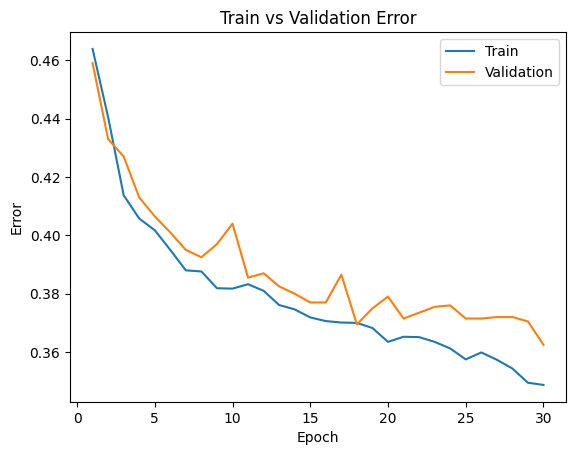

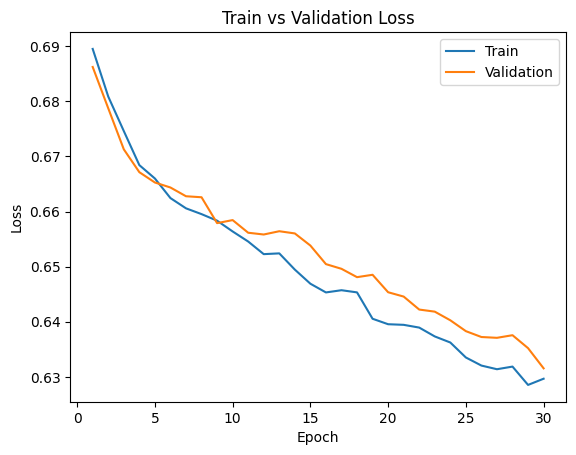

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=256, learning_rate=0.005)
model_path_small_bs256_lr005 = get_model_name("small", batch_size=256, learning_rate=0.005, epoch=29)
plot_training_curve(model_path_small_bs256_lr005)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

The model achieves a good fit with both validation and training error decreasing over the epochs. However, the validation error curve could be smoother and the loss could be lower so I will adjust the batch size to be slightly lower to capture more detail necessary to find patterns.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.476, Train loss: 0.6920740519251142 |Validation err: 0.456, Validation loss: 0.6880611994049766
Epoch 2: Train err: 0.442, Train loss: 0.6863447810922351 |Validation err: 0.4285, Validation loss: 0.6834783716635271
Epoch 3: Train err: 0.425875, Train loss: 0.6821919949281783 |Validation err: 0.413, Validation loss: 0.6794578433036804
Epoch 4: Train err: 0.417125, Train loss: 0.6771209410258702 |Validation err: 0.414, Validation loss: 0.6728074225512418
Epoch 5: Train err: 0.407, Train loss: 0.6726004169100807 |Validation err: 0.3835, Validation loss: 0.6687341603365812
Epoch 6: Train err: 0.39375, Train loss: 0.6666576848143623 |Validation err: 0.379, Validation loss: 0.6636751619252291
Epoch 7: Train err: 0.38725, Train loss: 0.6602013920034681 |Validation err: 0.381, Validation loss: 0.6604308919473127
Epoch 8: Train err: 0.371625, Train loss: 0.6541135126636142 |Validation err: 0.361, V

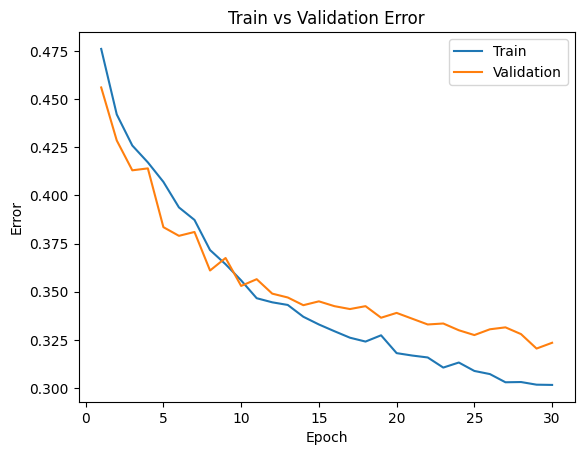

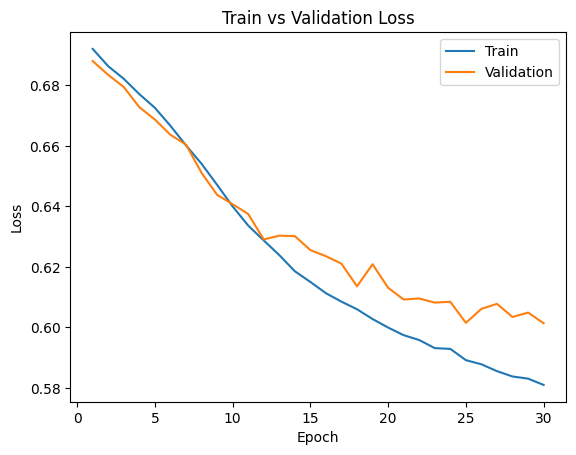

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=192, learning_rate=0.005)
model_path_small_bs192_lr005 = get_model_name("small", batch_size=192, learning_rate=0.005, epoch=29)
plot_training_curve(model_path_small_bs192_lr005)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=192, learning_rate=0.005, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<ipython-input-25-3e252ce1557e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

This model performed the best achieving the lowest validation loss and error of approximately 0.325 and 0.6.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=192)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net,test_loader,criterion)
print(f"The test classification error is: {test_err: .4f}")


Files already downloaded and verified
Files already downloaded and verified
The test classification error is:  0.3080


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In this case the test error is around the same as the validation error, only slightly lower. In most cases, the test error will be higher than the validation due to the hyperparameters being optimized to the validation set of examples.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The test data was only used at the very end to ensure that there is no data leakage. If the model was exposed to test examples before, it could have learned details specific to them, and the final results would not accurately represent the models performance on unseen examples.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

The best CNN model outperforms the 2-layer ANN model. As seen below, the test error it recieved was 0.355 and the test loss was 0.6507 which is slightly higher than the CNN model I trained above. This is possibly due to the fact that CNN models have better generalization and use convolution layers.

In [ ]:
class TwoLayerANN(nn.Module):
  def __init__(self):
    super(TwoLayerANN, self).__init__()
    self.name ="ann"
    self.layer1 = nn.Linear(3*32*32, 40)
    self.drop = nn.Dropout(p=0.3)
    self.layer2=nn.Linear(40,1)
  def forward(self, img):
    flattened = img.view(-1, 3*32*32)
    activation1 = self.drop(self.layer1(flattened))
    activation1 = F.relu(activation1)
    activation2 = self.layer2(activation1)
    return activation2.squeeze(1)
ann_model =TwoLayerANN()


train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], batch_size=192)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(ann_model.parameters(), lr=0.005, momentum=0.9)

train_net(ann_model, batch_size=192, learning_rate=0.005, num_epochs=29)

test_err_ann, test_loss_ann = evaluate(ann_model, test_loader, criterion)

print(f"Test Classification Error (ANN): {test_err_ann:.4f}")
print(f"Test Loss (ANN): {test_loss_ann:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43825, Train loss: 0.6799032602991376 |Validation err: 0.4085, Validation loss: 0.6635838367722251
Epoch 2: Train err: 0.39275, Train loss: 0.6586201645079113 |Validation err: 0.393, Validation loss: 0.662501335144043
Epoch 3: Train err: 0.385875, Train loss: 0.648727263723101 |Validation err: 0.392, Validation loss: 0.6615736267783425
Epoch 4: Train err: 0.3775, Train loss: 0.6446205264046079 |Validation err: 0.391, Validation loss: 0.6578156352043152
Epoch 5: Train err: 0.369625, Train loss: 0.6389119213535672 |Validation err: 0.391, Validation loss: 0.6575340086763556
Epoch 6: Train err: 0.360875, Train loss: 0.6339009517715091 |Validation err: 0.389, Validation loss: 0.6533009572462602
Epoch 7: Train err: 0.3595, Train loss: 0.6295249036380223 |Validation err: 0.39, Validation loss: 0.6502322012727911
Epoch 8: 